In [61]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import json
with open('/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_weights.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv('/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_trades.csv').iloc[:, 1:]


In [3]:
symbol_list = ttrades__.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in ttrades__.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
weights

{'TSLA': 0.17420799855438768,
 'NVDA': 0.13696693517022676,
 'AAPL': 0.10023373641816916,
 'MSFT': 0.10467300141772679,
 'AVGO': 0.07698902053627323,
 'SBUX': 0.0790869263496488,
 'AMD': 0.030287217010091606,
 'GOOG': 0.06259616627482918,
 'BAC': 0.056805302639254644,
 'QCOM': 0.025190453887818636,
 'AMZN': 0.02757812121505515,
 'HD': 0.03573121193888573,
 'BA': 0.02198114951948728,
 'DIS': 0.024661026395236287,
 'MU': 0.010524714558475388,
 'WMT': 0.005,
 'JNJ': 0.005,
 'INTC': 0.005}

In [4]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,34.0,504.0,524.0,279.795877,253.010232,-910.711955,-0.095733,2023-07-05,2023-08-02,28 days,TSLA
1,28.0,504.0,526.0,192.240502,185.493749,-188.909083,-0.035095,2023-07-05,2023-08-04,30 days,AAPL
2,17.0,504.0,529.0,336.262811,322.011093,-242.279208,-0.042383,2023-07-05,2023-08-09,35 days,MSFT
3,48.0,504.0,536.0,87.043588,82.000000,-242.092217,-0.057943,2023-07-05,2023-08-18,44 days,AVGO
4,11.0,504.0,583.0,130.695846,122.257034,-92.826927,-0.064568,2023-07-05,2023-10-25,112 days,AMZN
5,178.0,504.0,753.0,42.282471,123.470001,14451.380412,1.920123,2023-07-05,2024-07-01,362 days,NVDA
6,1.0,522.0,522.0,170.283917,168.355807,-1.928110,-0.011323,2023-07-31,2023-07-31,0 days,JNJ
7,5.0,522.0,556.0,332.810769,318.700396,-70.551863,-0.042398,2023-07-31,2023-09-18,49 days,HD
8,5.0,530.0,535.0,239.284572,224.549052,-73.677602,-0.061582,2023-08-10,2023-08-17,7 days,BA
9,5.0,530.0,535.0,53.784257,52.084613,-8.498219,-0.031601,2023-08-10,2023-08-17,7 days,WMT


'GOOG', '2024-04-03', 'C', 2, 
{'type': 'naked', 'specifics': [{'direction': 'long', 'rel_strike': 0.8, 'dte': 365, 'moneyness_width': 0.2}, {'direction': 'short', 'rel_strike': 0.7, 'dte': 365, 'moneyness_width': 0.2}], 'name': 'vertical_spread'}), {}
{'symbol': 'GOOG', 'end_date': 20240403, 'exp': 20250321, 'right': 'C', 'start_date': 20240306, 'strike': 230000, 'print_url': False, 'proxy': 'http://18.232.166.224:5500/thetadata', 'url': 'http://127.0.0.1:25510/v2/hist/option/open_interest', 'querystring': {'end_date': 20240403, 'root': 'GOOG', 'use_csv': 'true', 'exp': 20250321, 'right': 'C', 'start_date': 20240306, 'strike': 230000, 'rth': False}, 'headers': {'Accept': 'application/json'}, 'start_timer': 1739996726.9870741, 'end_timer': 1739996726.9870741, 'response': <Response [200]>, 'data': Empty DataFrame
Columns: [No data for the specified timeframe & contract.]

In [5]:
from dbase.DataAPI.ThetaData import retrieve_openInterest, list_contracts
retrieve_openInterest('GOOG', '2024-04-04', '2025-03-21', 'C', '2024-04-04', 230.0,print_url=True)
# c = list_contracts('GOOG', '2024-04-03', print_url=True)
# c[c.strike == 230.0]

http://127.0.0.1:25510/v2/hist/option/open_interest?end_date=20240404&root=GOOG&use_csv=true&exp=20250321&right=C&start_date=20240404&strike=230000&rth=False
http://18.232.166.224:5500/thetadata


,Open_interest,Date,time,Datetime
0,6,20240404,06:30:14,2024-04-04


In [6]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 100
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.5
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-07-01', 'GOOG'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .800,
   'dte': 365,
   'moneyness_width': 0.25},
   {'direction': 'short',
   'rel_strike': .70,
   'dte': 365,
   'moneyness_width': 0.25}],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
order

Saving to cache from db


{'result': 'SUCCESSFUL',
 'data': {'long': ['GOOG20250620C225'],
  'short': ['GOOG20250620C230'],
  'trade_id': '&L:GOOG20250620C225&S:GOOG20250620C230',
  'close': 1.5999999999999996}}

In [7]:
#Backtest class 
evb_backtest = OptionSignalBacktest(trades_, initial_capital=10_000)

In [8]:
evb_backtest.portfolio.initial_capital

10000

In [9]:
w_map = {x: w  * 0.75 for x, w in weights.items()}
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 100
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .800,
   'dte': 365,
   'moneyness_width': 0.35},
   {'direction': 'short',
   'rel_strike': .70,
   'dte': 365,
   'moneyness_width': 0.35}],
 'name': 'vertical_spread'}

evb_backtest.portfolio.max_contract_price = 2

In [10]:
signals = evb_backtest.bars.signal_df
signals

,Date,TSLA,AAPL,MSFT,AVGO,AMZN,NVDA,JNJ,HD,BA,WMT,INTC,QCOM,SBUX,AMD,MU,DIS,BAC,GOOG
0,2023-07-05,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2023-07-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2023-07-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2023-07-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2023-07-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2024-06-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
359,2024-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
360,2024-06-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
361,2024-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

31.0

In [12]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

        Date  TSLA  AAPL  MSFT  AVGO  AMZN  NVDA  JNJ  HD  BA  WMT  INTC  \
0 2023-07-05     1     1     1     1     1     1    0   0   0    0     0   

   QCOM  SBUX  AMD  MU  DIS  BAC  GOOG  
0     0     0    0   0    0    0     0  
Processing event: MARKET
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: FILL
Processing event: FILL
Processing event: FILL
Processing event: FILL
Processing event: FILL
Event queue is empty, processed 17 event(s)
        Date  TSLA  AAPL  MSFT  AVGO  AMZN  NVDA  JNJ  HD  BA  WMT  INTC  \
1 2023-07-06     0     0     0     0     0     0    0   0   0    0     0   

   QCOM  SBUX  AMD  MU  DIS  BAC  GOOG  
1     0     0    0   0    0    0     0  
Processing event: MARKET
Event queue is empty, processed 1 event(s)
        

In [13]:
pd.set_option('display.max_columns', 100)

In [45]:
eq2 = pd.DataFrame(evb_backtest.portfolio.all_holdings).set_index('datetime').copy()
eq2#.iloc[:, :19].sum(axis=1).plot()

,TSLA,AAPL,MSFT,AVGO,AMZN,NVDA,JNJ,HD,BA,WMT,INTC,QCOM,SBUX,AMD,MU,DIS,BAC,GOOG,cash,commission,total
datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-05,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,10000.000000,0.00000,10000.000000
2023-07-05,1000.0,600.000000,600.000000,0.0,0.0,760.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,9970.386427,0.04185,12930.386427
2023-07-06,962.5,675.000000,562.500000,0.0,0.0,710.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,9970.386427,0.04185,12880.386427
2023-07-07,800.0,600.000000,600.000000,0.0,0.0,740.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,9970.386427,0.04185,12710.386427
2023-07-10,787.5,540.000000,555.000000,0.0,0.0,710.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,9970.386427,0.04185,12562.886427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-25,0.0,300.000000,1155.000000,0.0,0.0,11890.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,407.500000,0.0,0.0,599.500000,0.0,9977.026636,0.18135,24329.026636
2024-06-26,0.0,435.000000,1185.000000,0.0,0.0,11890.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.000000,0.0,0.0,570.000000,0.0,9977.026636,0.18135,24417.026636
2024-06-27,0.0,440.000000,1192.500000,0.0,0.0,11890.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,385.000000,0.0,0.0,582.000000,0.0,9977.026636,0.18135,24466.526636


In [49]:
eq2.iloc[:, :19].head(10).sum(axis=1)#.plot()

datetime
2023-07-05    10000.000000
2023-07-05    12930.386427
2023-07-06    12880.386427
2023-07-07    12710.386427
2023-07-10    12562.886427
2023-07-11    12667.886427
2023-07-12    12887.886427
2023-07-13    13050.386427
2023-07-14    13070.386427
2023-07-17    13467.886427
dtype: float64

In [52]:
eq = pd.DataFrame(evb_backtest.portfolio.weighted_holdings).set_index('datetime').copy()

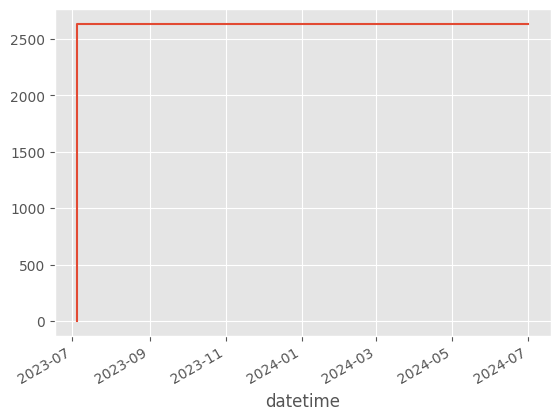

<Axes: xlabel='datetime'>

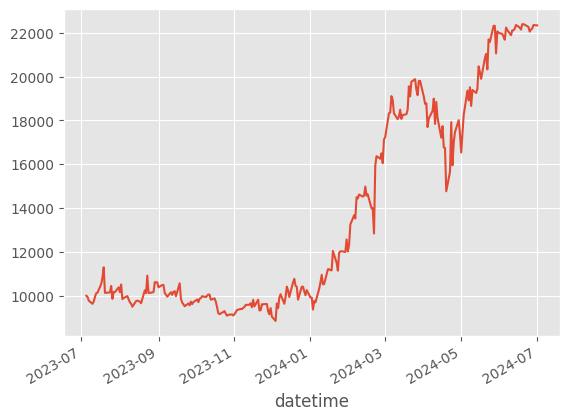

In [62]:
## Total & Sum of all columns have considerable difference
(eq.iloc[:, :19].sum(axis=1) - eq.total ).plot()
plt.show()

(eq.iloc[:, :19].sum(axis=1)).plot()

<Axes: >

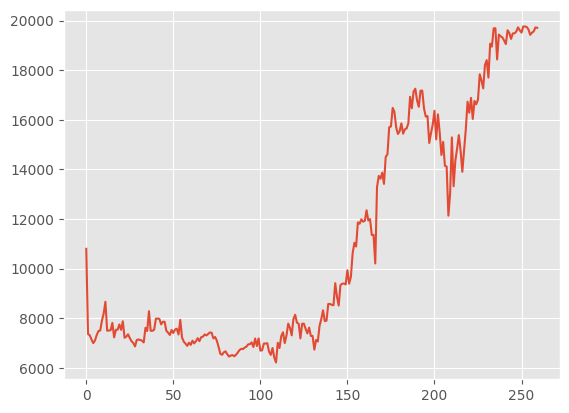

In [44]:
eq.iloc[:, :18].sum(axis=1).plot()

In [16]:
evb_backtest.trades.to_csv('/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options.csv')

In [42]:
evb_backtest.trades

,Ticker,PnL,EntryPrice,ExitPrice,ReturnPct,Quantity,EntryTime,ExitTime,Duration,Positions
0,TSLA,-209.997295,199.631604,157.632145,-21.038482,5,2023-07-05,2023-08-02,28,&L:TSLA20240621C333.33&S:TSLA20240621C340
1,AAPL,-0.929359,200.341188,200.031402,-0.154629,3,2023-07-05,2023-08-04,30,&L:AAPL20240621C230&S:AAPL20240621C240
2,MSFT,-120.044965,200.246938,160.231950,-19.982821,3,2023-07-05,2023-08-09,35,&L:MSFT20240621C370&S:MSFT20240621C375
3,AMZN,0.000000,NaN,NaN,NaN,0,2023-07-05,2023-10-25,112,&L:AMZN20240621C170&S:AMZN20240621C182.5
4,NVDA,11113.696594,190.358714,2968.782862,1459.572875,4,2023-07-05,2024-07-01,362,&L:NVDA20240621C770&S:NVDA20240621C800
5,BA,0.000000,NaN,NaN,NaN,0,2023-08-10,2023-08-17,7,&L:BA20240621C300&S:BA20240621C310
6,WMT,0.000000,NaN,NaN,NaN,0,2023-08-10,2023-08-17,7,&L:WMT20240621C175&S:WMT20240621C180
7,TSLA,-19.266677,199.806583,194.989914,-2.410666,4,2023-08-17,2023-10-20,64,&L:TSLA20240920C305&S:TSLA20240920C315
8,AAPL,-147.577284,198.423158,149.230730,-24.791677,3,2023-08-31,2023-09-07,7,&L:AAPL20240920C260&S:AAPL20240920C310
9,INTC,0.000000,NaN,NaN,NaN,0,2023-09-15,2023-09-20,5,&L:INTC20240621C40&S:INTC20240621C45


In [17]:
order_cache['2023-07-31']

{'HD': {'result': 'MAX_PRICE_TOO_LOW', 'data': None}}

In [18]:
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,34.0,504.0,524.0,279.795877,253.010232,-910.711955,-0.095733,2023-07-05,2023-08-02,28 days,TSLA
1,28.0,504.0,526.0,192.240502,185.493749,-188.909083,-0.035095,2023-07-05,2023-08-04,30 days,AAPL
2,17.0,504.0,529.0,336.262811,322.011093,-242.279208,-0.042383,2023-07-05,2023-08-09,35 days,MSFT
3,48.0,504.0,536.0,87.043588,82.000000,-242.092217,-0.057943,2023-07-05,2023-08-18,44 days,AVGO
4,11.0,504.0,583.0,130.695846,122.257034,-92.826927,-0.064568,2023-07-05,2023-10-25,112 days,AMZN
5,178.0,504.0,753.0,42.282471,123.470001,14451.380412,1.920123,2023-07-05,2024-07-01,362 days,NVDA
6,1.0,522.0,522.0,170.283917,168.355807,-1.928110,-0.011323,2023-07-31,2023-07-31,0 days,JNJ
7,5.0,522.0,556.0,332.810769,318.700396,-70.551863,-0.042398,2023-07-31,2023-09-18,49 days,HD
8,5.0,530.0,535.0,239.284572,224.549052,-73.677602,-0.061582,2023-08-10,2023-08-17,7 days,BA
9,5.0,530.0,535.0,53.784257,52.084613,-8.498219,-0.031601,2023-08-10,2023-08-17,7 days,WMT


In [19]:
t = {'p': {}}
t.setdefault('p', [])


{}

In [20]:
stats.print_stats(30)
print(stream.getvalue())
with open('bactest_data.txt', 'w') as f:
  stream.seek(0)
  f.write(stream.read())
  f.flush()

         163175362 function calls (162535385 primitive calls) in 664.251 seconds

   Ordered by: cumulative time
   List reduced from 2863 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  664.254  332.127 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000  664.254  332.127 {built-in method builtins.exec}
        1    0.035    0.035  664.254  664.254 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/backtest.py:37(run)
       64    0.000    0.000  552.857    8.638 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/portfolio.py:248(update_signal)
       64    0.006    0.000  552.854    8.638 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/portfolio.py:204(generate_order)
    62/31    0.012    0.000  552.787   17.832 /Users/chiemelienwanisobi/cloned_repos/QuantTools/tra

In [21]:
evb_backtest.trades

,Ticker,PnL,EntryPrice,ExitPrice,ReturnPct,Quantity,EntryTime,ExitTime,Duration,Positions
0,TSLA,-209.997295,199.631604,157.632145,-21.038482,5,2023-07-05,2023-08-02,28,&L:TSLA20240621C333.33&S:TSLA20240621C340
1,AAPL,-0.929359,200.341188,200.031402,-0.154629,3,2023-07-05,2023-08-04,30,&L:AAPL20240621C230&S:AAPL20240621C240
2,MSFT,-120.044965,200.246938,160.231950,-19.982821,3,2023-07-05,2023-08-09,35,&L:MSFT20240621C370&S:MSFT20240621C375
3,AMZN,0.000000,NaN,NaN,NaN,0,2023-07-05,2023-10-25,112,&L:AMZN20240621C170&S:AMZN20240621C182.5
4,NVDA,11113.696594,190.358714,2968.782862,1459.572875,4,2023-07-05,2024-07-01,362,&L:NVDA20240621C770&S:NVDA20240621C800
5,BA,0.000000,NaN,NaN,NaN,0,2023-08-10,2023-08-17,7,&L:BA20240621C300&S:BA20240621C310
6,WMT,0.000000,NaN,NaN,NaN,0,2023-08-10,2023-08-17,7,&L:WMT20240621C175&S:WMT20240621C180
7,TSLA,-19.266677,199.806583,194.989914,-2.410666,4,2023-08-17,2023-10-20,64,&L:TSLA20240920C305&S:TSLA20240920C315
8,AAPL,-147.577284,198.423158,149.230730,-24.791677,3,2023-08-31,2023-09-07,7,&L:AAPL20240920C260&S:AAPL20240920C310
9,INTC,0.000000,NaN,NaN,NaN,0,2023-09-15,2023-09-20,5,&L:INTC20240621C40&S:INTC20240621C45


In [22]:
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,34.0,504.0,524.0,279.795877,253.010232,-910.711955,-0.095733,2023-07-05,2023-08-02,28 days,TSLA
1,28.0,504.0,526.0,192.240502,185.493749,-188.909083,-0.035095,2023-07-05,2023-08-04,30 days,AAPL
2,17.0,504.0,529.0,336.262811,322.011093,-242.279208,-0.042383,2023-07-05,2023-08-09,35 days,MSFT
3,48.0,504.0,536.0,87.043588,82.000000,-242.092217,-0.057943,2023-07-05,2023-08-18,44 days,AVGO
4,11.0,504.0,583.0,130.695846,122.257034,-92.826927,-0.064568,2023-07-05,2023-10-25,112 days,AMZN
5,178.0,504.0,753.0,42.282471,123.470001,14451.380412,1.920123,2023-07-05,2024-07-01,362 days,NVDA
6,1.0,522.0,522.0,170.283917,168.355807,-1.928110,-0.011323,2023-07-31,2023-07-31,0 days,JNJ
7,5.0,522.0,556.0,332.810769,318.700396,-70.551863,-0.042398,2023-07-31,2023-09-18,49 days,HD
8,5.0,530.0,535.0,239.284572,224.549052,-73.677602,-0.061582,2023-08-10,2023-08-17,7 days,BA
9,5.0,530.0,535.0,53.784257,52.084613,-8.498219,-0.031601,2023-08-10,2023-08-17,7 days,WMT


In [23]:
from copy import deepcopy
test_data  =deepcopy(evb_backtest.portfolio.options_data['AAPL20240621C200'] - evb_backtest.portfolio.options_data['AAPL20240621C210'])
test_data[(test_data.index == '2023-07-05') | (test_data.index == '2023-10-26')]

KeyError: 'AAPL20240621C200'

In [33]:
evb_backtest.portfolio.all_positions


[{'GOOGL': {},
  'AMD': {},
  'MSFT': {},
  'datetime': Timestamp('2023-07-24 00:00:00')},
 {'GOOGL': {'position': {'long': ['GOOGL20240621P115'],
    'short': ['GOOGL20240621P100'],
    'trade_id': '&L:GOOGL20240621P115&S:GOOGL20240621P100',
    'close': 5.0},
   'quantity': 66.0,
   'market_value': 33000.0},
  'AMD': {'position': {'long': ['AMD20240621P110'],
    'short': ['AMD20240621P100'],
    'trade_id': '&L:AMD20240621P110&S:AMD20240621P100',
    'close': 4.75},
   'quantity': 69.47368421052632,
   'market_value': 33000.0},
  'MSFT': {},
  'datetime': Timestamp('2023-07-24 00:00:00')},
 {'GOOGL': {},
  'AMD': {},
  'MSFT': {},
  'datetime': Timestamp('2023-07-25 00:00:00')},
 {'GOOGL': {'position': {'long': ['GOOGL20240621C135'],
    'short': ['GOOGL20240621C147.5'],
    'trade_id': '&L:GOOGL20240621C135&S:GOOGL20240621C147.5',
    'close': 4.85},
   'quantity': 68.04121145934306,
   'market_value': 32999.98755778139},
  'AMD': {'position': {'long': ['AMD20240621P110'],
    'sho

In [34]:
evb_backtest.portfolio.options_data['GOOGL20240621P115'] - evb_backtest.portfolio.options_data['GOOGL20240621P100']

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-07-24,4.16,4.13,4.05,4.07,-9,-134,5.85,38,4.15,5.000,5.381509
2023-07-24,4.16,4.13,4.05,4.07,-9,-134,5.85,38,4.15,5.000,5.381509
2023-07-25,4.25,4.25,3.93,3.91,-3198,2,3.30,27,4.35,3.825,3.857051
2023-07-25,4.25,4.25,3.93,3.91,-3198,2,3.30,27,4.35,3.825,3.857051
2023-07-26,2.88,3.12,2.88,3.12,-910,18,3.02,-191,3.05,3.035,2.938961
2023-07-26,2.88,3.12,2.88,3.12,-910,18,3.02,-191,3.05,3.035,2.938961
2023-07-27,2.88,2.85,2.70,2.85,-25,-23,3.07,14,3.10,3.085,3.114296
2023-07-27,2.88,2.85,2.70,2.85,-25,-23,3.07,14,3.10,3.085,3.114296
2023-07-28,2.66,2.69,2.65,2.64,174,62,1.10,6,2.77,1.935,1.839688


In [24]:
from trade.helpers.helper import generate_option_tick
import pandas as pd

tick = 'AAPL'
exp = '2024-03-12'
right = 'C'
strike = 145.0
option_tick = generate_option_tick(tick, right, exp, strike)
option_tick


'AAPL20240312000145C'

In [35]:
evb_backtest.portfolio.current_positions

{'GOOGL': {}, 'AMD': {}, 'MSFT': {}}

In [26]:
stats.print_stats(20)  # Show the top 20 functions by cumulative time
print(stream.getvalue())

         53676519 function calls (52386882 primitive calls) in 216.194 seconds

   Ordered by: cumulative time
   List reduced from 2937 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  216.195  108.097 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000  216.195  108.097 {built-in method builtins.exec}
        1    0.000    0.000  216.195  216.195 /var/folders/j0/80hkbygd4lb27h9mw76gqzpw0000gn/T/ipykernel_40825/2620833521.py:1(<module>)
        1    0.003    0.003  216.195  216.195 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/backtest.py:55(run)
       21    0.000    0.000  215.775   10.275 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/portfolio.py:270(update_signal)
       21    0.003    0.000  215.775   10.275 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriv

In [27]:
trades = evb_backtest.portfolio.get_trades()
print(trades.to_string())

KeyError: 'option'

In [80]:
#Get all holdings
holdings = evb_backtest.get_all_holdings()
print(holdings.to_string())

               AMD    MSFT   AMZN   GOOGL   AAPL      cash  commission     total
datetime                                                                        
2024-03-05     0.0     0.0    0.0     0.0    0.0  100000.0         0.0  100000.0
2024-03-05     0.0     0.0    0.0     0.0    0.0  100000.0         0.0  100000.0
2024-03-05  3680.0     0.0    0.0     0.0    0.0   96320.0         0.0  100000.0
2024-03-05  3680.0  1624.0    0.0     0.0    0.0   94696.0         0.0  100000.0
2024-03-05  3680.0  1624.0  416.0     0.0    0.0   94280.0         0.0  100000.0
2024-03-06  4596.0  1402.0    0.0     0.0    0.0   94280.0         0.0  100278.0
2024-03-07  4804.0  1770.0    0.0     0.0    0.0   94280.0         0.0  100854.0
2024-03-08  4630.0  1880.0    0.0     0.0    0.0   94280.0         0.0  100790.0
2024-03-11  3746.0     0.0  380.0     0.0    0.0   94280.0         0.0   98406.0
2024-03-12  3310.0  1990.0  378.0     0.0    0.0   94280.0         0.0   99958.0
2024-03-13  3178.0  2096.0  

In [36]:
positions = evb_backtest.get_all_positions()
print(positions.to_string())

                             AMD                   AAPL                   MSFT                   GOOGL
datetime                                                                                              
2024-03-04                  None                   None                   None                    None
2024-03-04                  None                   None                   None                    None
2024-03-05  AMD-20240816-270.0-C                   None  MSFT-20240816-480.0-C                    None
2024-03-06  AMD-20240816-270.0-C                   None  MSFT-20240816-480.0-C                    None
2024-03-07  AMD-20240816-270.0-C                   None  MSFT-20240816-480.0-C                    None
2024-03-08  AMD-20240816-270.0-C                   None  MSFT-20240816-480.0-C                    None
2024-03-11  AMD-20240816-270.0-C                   None  MSFT-20240816-480.0-C                    None
2024-03-12  AMD-20240816-270.0-C                   None  MSFT-20240816-48

In [64]:
evb_backtest.portfolio.all_positions

[{'AMD': {'quantity': 0.0, 'option': None},
  'MSFT': {'quantity': 0.0, 'option': None},
  'AMZN': {'quantity': 0.0, 'option': None},
  'GOOGL': {'quantity': 0.0, 'option': None},
  'AAPL': {'quantity': 0.0, 'option': None},
  'datetime': Timestamp('2024-03-04 00:00:00')},
 {'AMD': {'quantity': 0.0, 'option': None},
  'MSFT': {'quantity': 0.0, 'option': None},
  'AMZN': {'quantity': 0.0, 'option': None},
  'GOOGL': {'quantity': 0.0, 'option': None},
  'AAPL': {'quantity': 0.0, 'option': None},
  'datetime': Timestamp('2024-03-04 00:00:00')},
 {'AMD': {'quantity': 2,
   'option': 'AMD-20240920-240.0-C',
   'entry_price': 2185.0},
  'MSFT': {'quantity': 2,
   'option': 'MSFT-20250117-540.0-C',
   'entry_price': 778.0},
  'AMZN': {'quantity': 2,
   'option': 'AMZN-20250321-205.0-C',
   'entry_price': 0.0},
  'GOOGL': {'quantity': 0.0, 'option': None},
  'AAPL': {'quantity': 0.0, 'option': None},
  'datetime': Timestamp('2024-03-05 00:00:00')},
 {'AMD': {'quantity': 2,
   'option': 'AMD-20

In [7]:
from pprint import pprint

print('All positions:')
pprint(portfolio.all_positions)

print('\nCurrent holdings:')
pprint(portfolio.current_holdings)

print('\nCurrent positions:')
pprint(portfolio.current_positions)

All positions:
[{'AAPL': {'option': None, 'quantity': 0.0},
  'AMD': {'option': None, 'quantity': 0.0},
  'AMZN': {'option': None, 'quantity': 0.0},
  'GOOGL': {'option': None, 'quantity': 0.0},
  'MSFT': {'option': None, 'quantity': 0.0},
  'datetime': '20240226'},
 {'AAPL': {'option': None, 'quantity': 0.0},
  'AMD': {'option': None, 'quantity': 0.0},
  'AMZN': {'option': None, 'quantity': 0.0},
  'GOOGL': {'option': None, 'quantity': 0.0},
  'MSFT': {'option': None, 'quantity': 0.0},
  'datetime': Timestamp('2024-02-26 00:00:00')},
 {'AAPL': {'option': None, 'quantity': 0.0},
  'AMD': {'option': None, 'quantity': 0.0},
  'AMZN': {'option': None, 'quantity': 0.0},
  'GOOGL': {'option': None, 'quantity': 0.0},
  'MSFT': {'option': None, 'quantity': 0.0},
  'datetime': Timestamp('2024-02-26 00:00:00')}]

Current holdings:
{'AAPL': 0.0,
 'AMD': 0.0,
 'AMZN': 0.0,
 'GOOGL': 0.0,
 'MSFT': 0.0,
 'cash': 100000,
 'commission': 0.0,
 'total': 100000}

Current positions:
{'AAPL': {'option': N

# Test RiskManager 

In [13]:
from EventDriven.riskmanager import RiskManager
from dbase.DataAPI.ThetaData import list_contracts, retrieve_option_ohlc, is_theta_data_retrieval_successful #type: ignore
import datetime
import pandas as pd
import pandas_market_calendars as mcal
import unittest
import numpy as np
import pprint as pp

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']


#generate date range 
nyse = mcal.get_calendar('NYSE')
year_ago_date = datetime.datetime.now() - datetime.timedelta(days=365)
schedule = nyse.schedule(start_date=year_ago_date, end_date=datetime.datetime.now())
date_range = mcal.date_range(schedule, frequency='1D')
dates = [date.strftime('%Y-%m-%d') for date in date_range]




class RiskManagerOperations(unittest.TestCase):
    def __init__(self):
        self.events = Queue(maxsize=0)  
        self.bars = HistoricTradeDataHandler(self.events, trades)
        self.risk_manager = RiskManager(bars=self.bars, events=self.events, initial_capital=1000000)
        
    def test_order_picker(self):
        ticker = np.random.choice(tickers)
        contract_date = np.random.choice(dates)
        contracts = list_contracts(ticker, pd.to_datetime(contract_date).strftime('%Y%m%d'))
        self.assertTrue(is_theta_data_retrieval_successful(contracts))
        
        contract = contracts.sample()
        print(contract)
        contract_right = contract['right'].values[0]
        contract_expiration = f"{contract['expiration'].values[0]}"
        contract_strike = float(contract['strike'].values[0])
        max_close = np.random.randint(1, 10)
        
        #order settings 
        moneyness_width = np.random.uniform(0.05, 0.1)
        rel_strike_long = np.random.uniform(1.05, 1.3) 
        rel_strike_short = np.random.uniform(0.7, 0.95)
        dte = np.random.randint(30, 365)
        
        order_settings = {
            'type': 'spread',
            'specifics': [
                {'direction': 'long', 'rel_strike': rel_strike_long, 'dte': dte, 'moneyness_width': moneyness_width},
                {'direction': 'short', 'rel_strike': rel_strike_short, 'dte': dte, 'moneyness_width': moneyness_width} 
            ],
            'name': 'vertical_spread'
        }
       
        try:
            self.order = self.risk_manager.OrderPicker.get_order(ticker, contract_expiration, contract_right, max_close, order_settings)
            self.assertIsInstance(self.order, dict)
            self.assertIsInstance(self.order['long'], list)
            self.assertIsInstance(self.order['short'], list)
            self.assertGreater(len(self.order['long']), 0)
            self.assertGreater(len(self.order['short']), 0)
            self.assertIsInstance(self.order['close'], float)
        except AssertionError as e:
            print(f"AssertionError: {e}")
            pp.pprint(contract)
            print(f"Ticker: {ticker}")
            print(f"Contract Date: {contract_date}")
            print(f"Contract Right: {contract_right}")
            print(f"Contract Expiration: {contract_expiration}")
            print(f"Contract Strike: {contract_strike}")
            print(f"Max Close: {max_close}")
            print(f"Order Settings: {order_settings}")
            raise
        except Exception as e:
            print(f"Exception: {e}")
            pp.pprint(contract)
            print(f"Ticker: {ticker}")
            print(f"Contract Date: {contract_date}")
            print(f"Contract Right: {contract_right}")
            print(f"Contract Expiration: {contract_expiration}, type: {type(contract_expiration)}")
            print(f"Contract Strike: {contract_strike}, type: {type(contract_strike)}")
            print(f"Max Close: {max_close}")
            print(f"Order Settings: {order_settings}")
            raise


ops = RiskManagerOperations()
ops.test_order_picker()

      root  expiration  strike right
3444  NVDA    20240301   270.0     C
Exception: Cannot set a DataFrame with multiple columns to the single column option_id
      root  expiration  strike right
3444  NVDA    20240301   270.0     C
Ticker: NVDA
Contract Date: 2024-02-09
Contract Right: C
Contract Expiration: 20240301, type: <class 'str'>
Contract Strike: 270.0, type: <class 'float'>
Max Close: 2
Order Settings: {'type': 'spread', 'specifics': [{'direction': 'long', 'rel_strike': 1.2305088940545148, 'dte': 284, 'moneyness_width': 0.08149699520032436}, {'direction': 'short', 'rel_strike': 0.9364378888363725, 'dte': 284, 'moneyness_width': 0.08149699520032436}], 'name': 'vertical_spread'}


ValueError: Cannot set a DataFrame with multiple columns to the single column option_id

In [15]:
from trade.assets.Stock import Stock
NVDA = Stock('NVDA', run_chain = False)

In [14]:
def generate_option_to_buy(underlier: Stock, contract_time):
        """
        Buy an option based on the underlier.
        """
        time = contract_time
        next_day_time = time + pd.DateOffset(days=1)
        print(time, next_day_time)
        option_spot = underlier.spot(ts=True, ts_start = time, ts_end = next_day_time)
        option_spot = option_spot.iloc[0] 
        stock_price = option_spot['open']#use open price as spot price on the assumption of making trades at start of day
        oom_benchmark = 0.1#10% out of the money 
        expiry_benchmark = time + pd.DateOffset(months=5)
        oom_price = stock_price * (1 + oom_benchmark)
        time_str = time.strftime("%Y%m%d")
        contracts = list_contracts(underlier.ticker, time_str)
        print(contracts)
        contracts = contracts[contracts['right'] == 'C'] 
        
        
        #Filter out contracts that are out of the money
        contracts = contracts[contracts['strike'] >= oom_price]
        
        print('comparing expiry')
        print(type(expiry_benchmark))
        print(type(contracts['expiration']))
        #filter out contracts that are  below the expiry benchmark
        contracts = contracts[pd.to_datetime(contracts['expiration'], format="%Y%m%d") >= expiry_benchmark]
        
        #select a random contract to buy
        contract = contracts.sample(n=1); 
        
        return contract
                

In [8]:
appl = Stock('AAPL')
c_time = pd.to_datetime('2024-05-06', format="%Y-%m-%d")
c_time_next = c_time + pd.DateOffset(days=1)
aapl_spot = appl.spot(ts=True, ts_start = c_time, ts_end = c_time_next)
aapl_spot.iloc[0]['open']


182.35000610351562

In [15]:
option = generate_option_to_buy(appl, c_time)
option

2024-05-06 00:00:00 2024-05-07 00:00:00
      root  expiration  strike right
0     AAPL    20241018   220.0     C
1     AAPL    20250919   215.0     C
2     AAPL    20241115   220.0     C
3     AAPL    20250321   220.0     C
4     AAPL    20250321   220.0     P
...    ...         ...     ...   ...
1060  AAPL    20240621   220.0     C
1061  AAPL    20240621   220.0     P
1062  AAPL    20240719   220.0     C
1063  AAPL    20250620   215.0     C
1064  AAPL    20240816   220.0     C

[1065 rows x 4 columns]
comparing expiry
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas.core.series.Series'>


,root,expiration,strike,right
456,AAPL,20250117,235.0,C
